In [1]:
import numpy as np
import pandas as pd
import time
import json
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
import umap
from MulticoreTSNE import MulticoreTSNE as TSNE

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Загрузка основного датафрейма с результатами голосований
df_full = pd.read_csv('./data/df_full_cr_0.csv', index_col=0)

In [3]:
df_full.head()

,law_name,vote_result,Авдеев Александр Александрович,Адучиев Батор Канурович,Азимов Рахим Азизбоевич,Аксаков Анатолий Геннадьевич,Алексеева Татьяна Олеговна,Альшевских Андрей Геннадьевич,Ананских Игорь Александрович,Аникеев Григорий Викторович,...,Эмиргамзаев Абдулгамид Гасанович,Юмашева Инга Альбертовна,Юрков Дмитрий Васильевич,Ющенко Александр Андреевич,Ямпольская Елена Александровна,Яровая Ирина Анатольевна,Антошкин Николай Тимофеевич,Зиннуров Ирек Хайдарович,Кобзев Юрий Викторович,Шурчанов Валентин Сергеевич
113991,(за основу) О проекте порядка работы Государст...,принят,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,0.0,0.0,0.0,0.0
113990,Регистрация 12:01.02,принят,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
113989,(первое чтение) О проекте федерального закона ...,отклонен,0,0,0,-1,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
113988,(первое чтение) О проекте федерального закона ...,отклонен,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,-1.0
113987,(первое чтение) О проекте федерального закона ...,принят,-1,0,-1,-1,0,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1.0,-1.0,-1.0,-1.0


2 - не голосовал, 1 - "против", 0 - воздержался, -1 - "за"

In [4]:
# Загрузка словаря со списком депутатов и их партий
b_file = open("./data/dep_part_dict.json", "r")
dep_part_dict = json.load(b_file)
b_file.close()

In [5]:
dep_df = pd.Series(dep_part_dict)

In [6]:
dep_df_cr = dep_df.loc[df_full.columns[2:].values]

In [7]:
dep_df_cr[dep_df_cr == 'КПРФ'].index

Index(['Арефьев Николай Васильевич', 'Афонин Юрий Вячеславович',
       'Бифов Анатолий Жамалович', 'Блоцкий Владимир Николаевич',
       'Бортко Владимир Владимирович', 'Гаврилов Сергей Анатольевич',
       'Ганзя Вера Анатольевна', 'Дорохин Павел Сергеевич',
       'Езерский Николай Николаевич', 'Зюганов Геннадий Андреевич',
       'Иванов Николай Николаевич', 'Казанков Сергей Иванович',
       'Калашников Леонид Иванович', 'Кашин Владимир Иванович',
       'Коломейцев Николай Васильевич', 'Корниенко Алексей Викторович',
       'Кравец Александр Алексеевич', 'Куринный Алексей Владимирович',
       'Лебедев Олег Александрович', 'Мельников Иван Иванович',
       'Новиков Дмитрий Георгиевич', 'Осадчий Николай Иванович',
       'Пантелеев Сергей Михайлович', 'Парфенов Денис Андреевич',
       'Плетнева Тамара Васильевна', 'Поздняков Владимир Георгиевич',
       'Пономарёв Алексей Алексеевич', 'Рашкин Валерий Федорович',
       'Савицкая Светлана Евгеньевна', 'Синельщиков Юрий Петрович',


In [8]:
# Транспонирование матрицы для последующей кластеризации
df_t = df_full.transpose().drop(index=['law_name', 'vote_result'])
df_t.head()

,113991,113990,113989,113988,113987,113986,113985,113984,113983,113982,...,96016,96015,96014,96013,96012,96011,96010,96009,96008,96007
Авдеев Александр Александрович,-1,0,0,0,-1,-1,-1,-1,0,-1,...,-1,0,-1,-1,-1,-1,-1,-1,-1,0
Адучиев Батор Канурович,-1,0,0,0,0,0,0,0,0,0,...,-1,0,-1,-1,-1,-1,-1,-1,-1,0
Азимов Рахим Азизбоевич,-1,0,0,0,-1,-1,-1,-1,0,-1,...,-1,0,-1,-1,-1,-1,-1,-1,-1,0
Аксаков Анатолий Геннадьевич,-1,0,-1,0,-1,-1,-1,-1,-1,-1,...,-1,0,-1,-1,-1,-1,-1,-1,-1,0
Алексеева Татьяна Олеговна,-1,0,0,0,0,0,0,0,0,0,...,-1,0,-1,-1,-1,-1,-1,-1,-1,0


In [9]:
X = df_t # Матрица для кластеризации
y = dep_df_cr # Данные о партийной принадлежности

In [10]:
def plot(x1, x2, hue=None, name=None):
    plt.figure(figsize=(10,10))
    sns.scatterplot(x1, x2, hue=hue, palette="bright")
    plt.title(name, fontsize=18)
    plt.show()

### PCA

In [11]:
pca = PCA(random_state=7)
pca.fit(X)

PCA(random_state=7)

In [12]:
PCA_transformed = PCA(n_components=2, random_state=7).fit_transform(X)
PCA_transformed.shape

(407, 2)

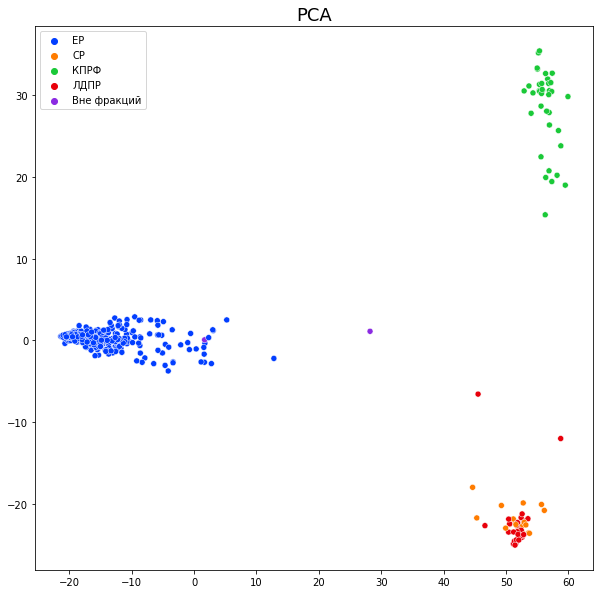

In [13]:
plot(PCA_transformed[:, 0], PCA_transformed[:, 1], hue=y, name='PCA')

### UMAP

In [14]:
reducer = umap.UMAP(random_state=7)
embedding = reducer.fit_transform(X)

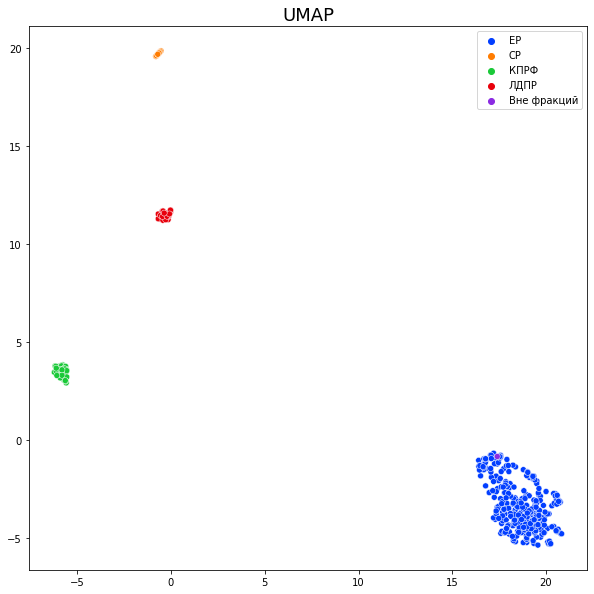

In [15]:
plot(embedding[:, 0], embedding[:, 1], hue=y, name='UMAP')

### t-SNE

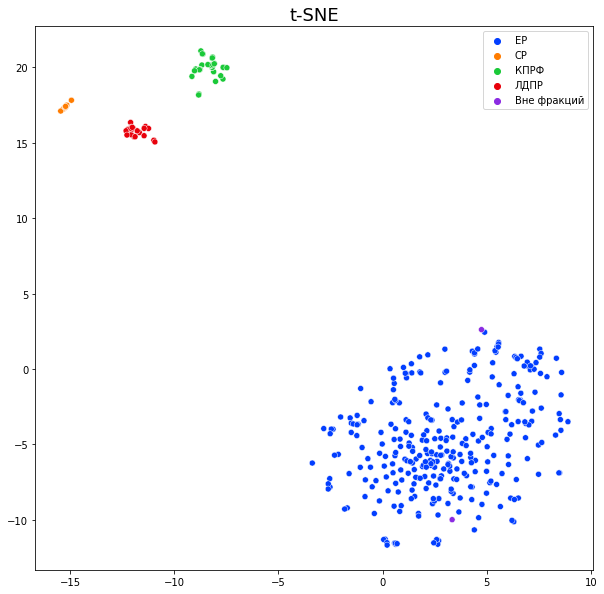

In [16]:
tsne = TSNE(perplexity=30, n_jobs=-1, random_state=7)
tsne_transformed = tsne.fit_transform(X)

plot(tsne_transformed[:,0], tsne_transformed[:,1], hue=y, name='t-SNE')

# Кластеризация

## K-means алгоритм

Elbow method

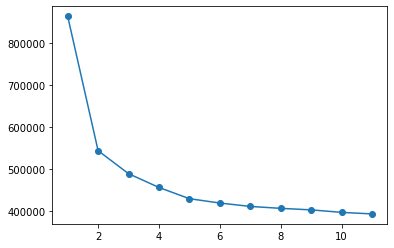

In [17]:
inertia = []
for i in range(1,12):
    kmeans = KMeans(n_clusters=i, random_state=7, n_jobs=-1).fit(X)
    inertia_i = kmeans.inertia_
    inertia.append(inertia_i)
    
plt.plot(range(1,12), inertia, marker='o')

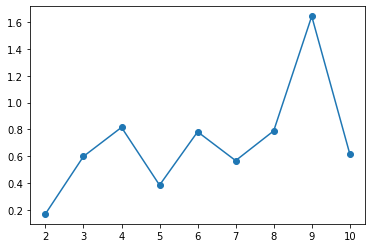

In [18]:
D = []
for i in range(1,10):
    Di = (inertia[i] - inertia[i+1]) / (inertia[i-1] - inertia[i])
    D.append(Di)
    
plt.plot(range(2,11), D, marker='o')

Silhouette plot

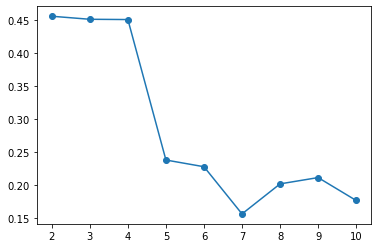

In [19]:
silhouette = []
for i in tqdm(range(2,11)):
    kmeans = KMeans(n_clusters=i, random_state=7, n_jobs=-1).fit(X)
    labels = kmeans.labels_
    score = silhouette_score(X, labels)
    silhouette.append(score)

plt.plot(range(2,11), silhouette, marker='o')

По силуэтному графику видно, что максимальное число кластеров, на которое хорошо делятся данные, равно 4

In [20]:
kmeans_4 = KMeans(n_clusters=4, random_state=7, n_jobs=-1).fit(X)
labels_km_4 = kmeans_4.labels_

### PCA

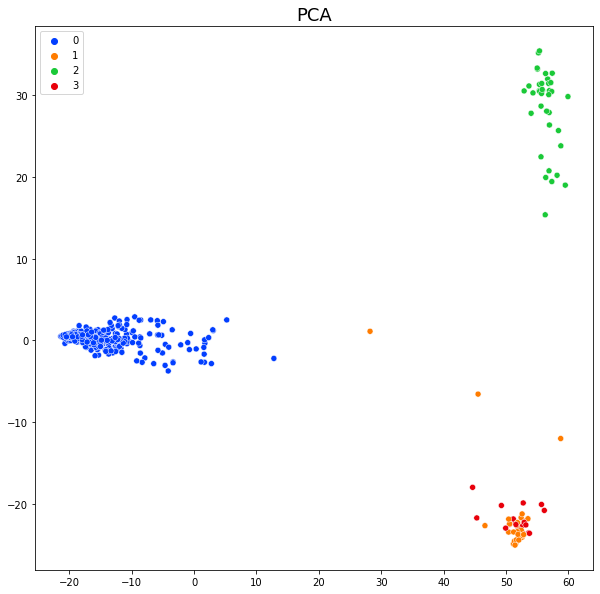

In [21]:
plot(PCA_transformed[:, 0], PCA_transformed[:, 1], hue=labels_km_4, name='PCA')

### UMAP

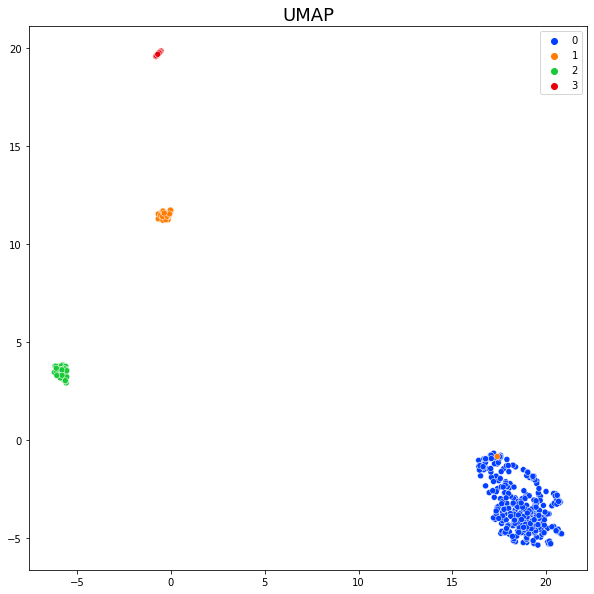

In [22]:
plot(embedding[:, 0], embedding[:, 1], hue=labels_km_4, name='UMAP')

### t-SNE

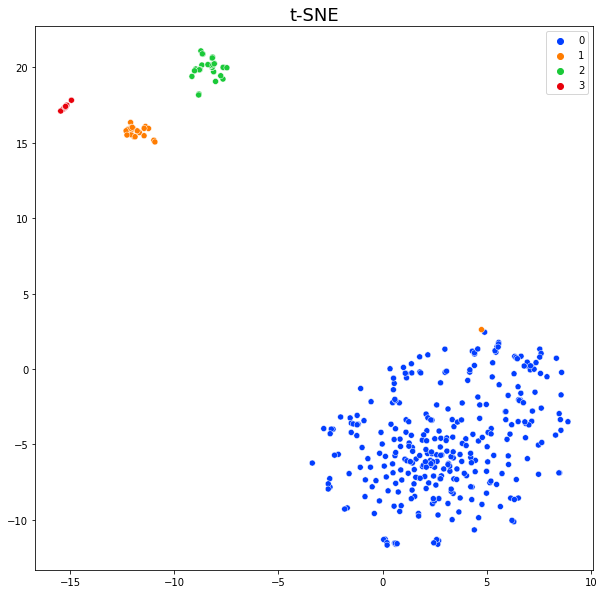

In [23]:
plot(tsne_transformed[:,0], tsne_transformed[:,1], hue=labels_km_4, name='t-SNE')

При использовании UMAP/t-SNE и алгоритма K-means разделение на партийные кластеры происходит отлично. PCA даёт менее внятный визуальный результат

## hierarhical алгоритм

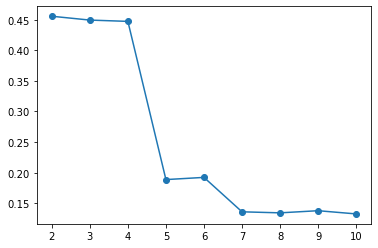

In [24]:
silhouette = []
for i in tqdm(range(2,11)):
    agg = AgglomerativeClustering(n_clusters=i).fit(X)
    labels = agg.labels_
    score = silhouette_score(X, labels, random_state=7)
    silhouette.append(score)
    
plt.plot(range(2,11), silhouette, marker='o')

In [25]:
agg_4 = AgglomerativeClustering(n_clusters=4).fit(X)
labels_hier_4 = agg_4.labels_

### PCA

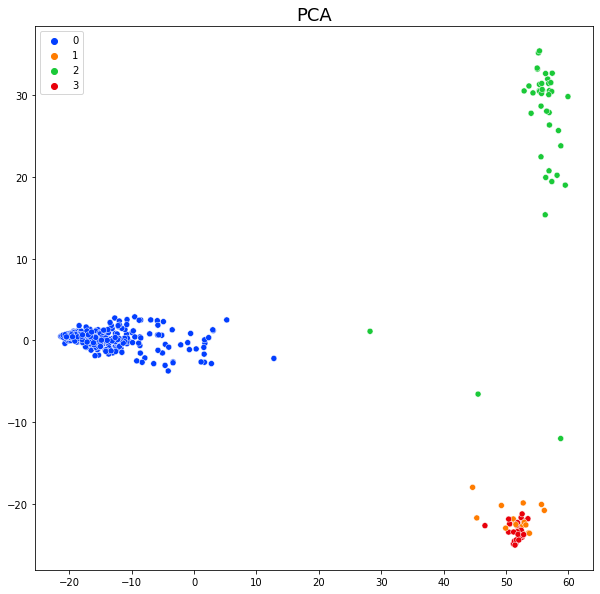

In [26]:
plot(PCA_transformed[:, 0], PCA_transformed[:, 1], hue=labels_hier_4, name='PCA')

### UMAP

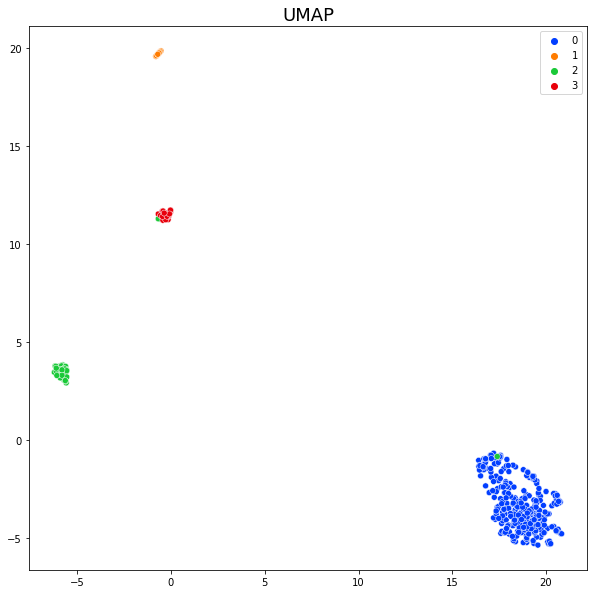

In [27]:
plot(embedding[:, 0], embedding[:, 1], hue=labels_hier_4, name='UMAP')

### t-SNE

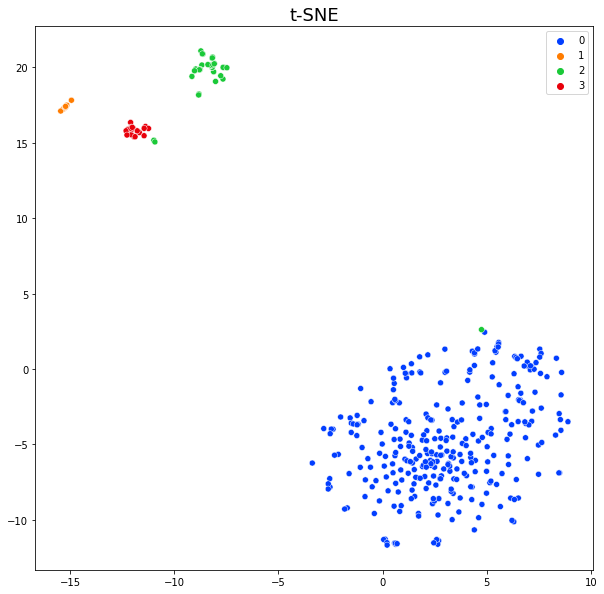

In [28]:
plot(tsne_transformed[:,0], tsne_transformed[:,1], hue=labels_hier_4, name='t-SNE')

Алгоритм hierarhical справился с кластеризацией на уровне K-means

### Определение возможности кластеризации внутри партий

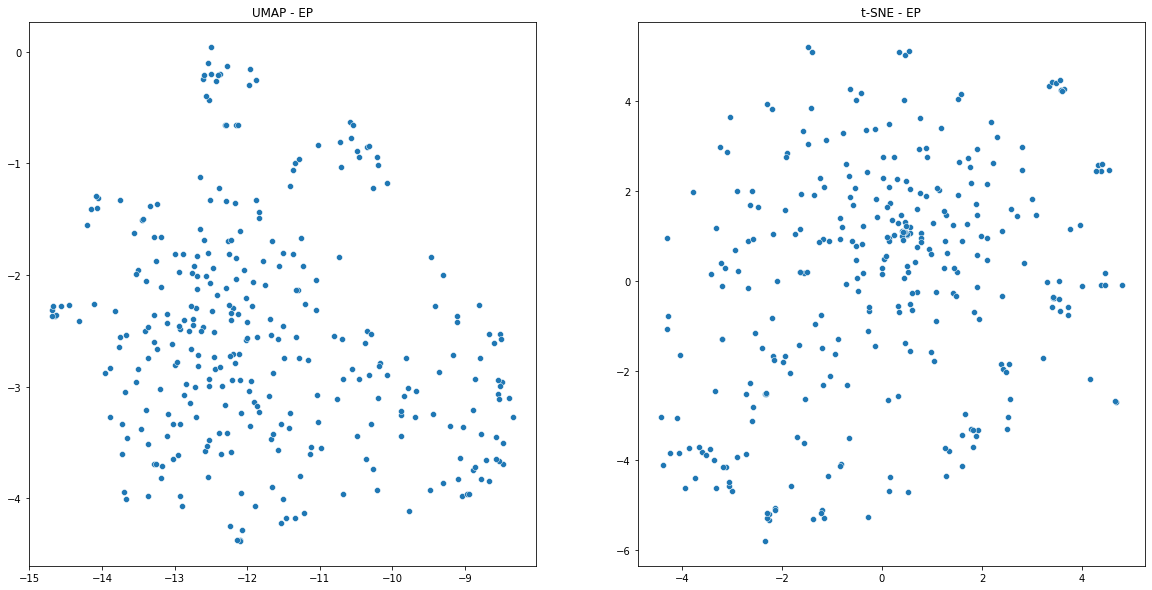

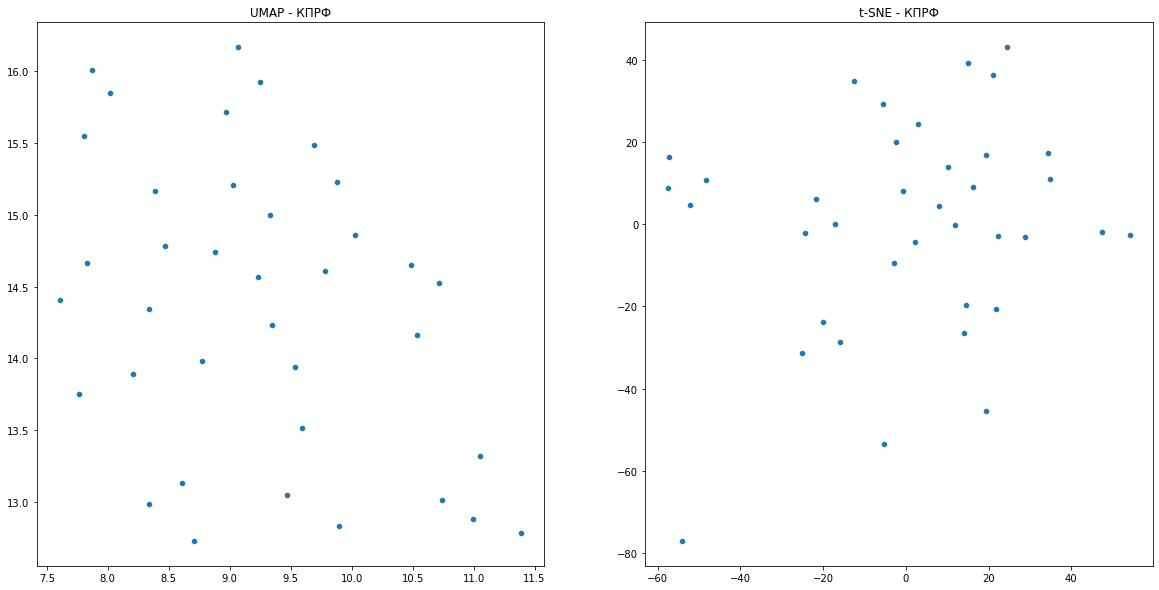

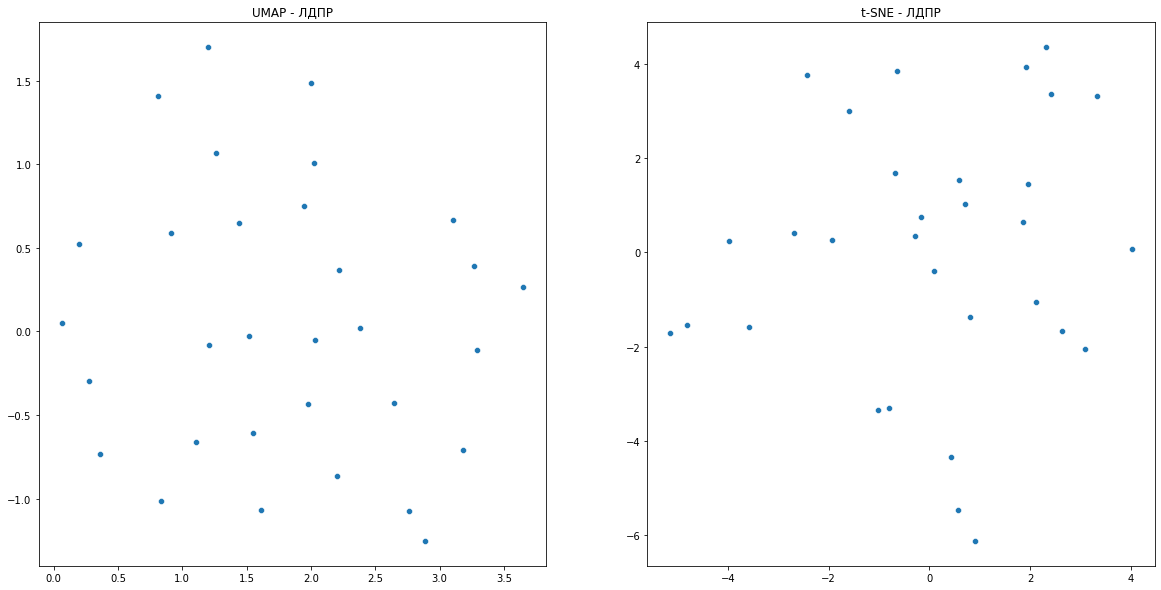

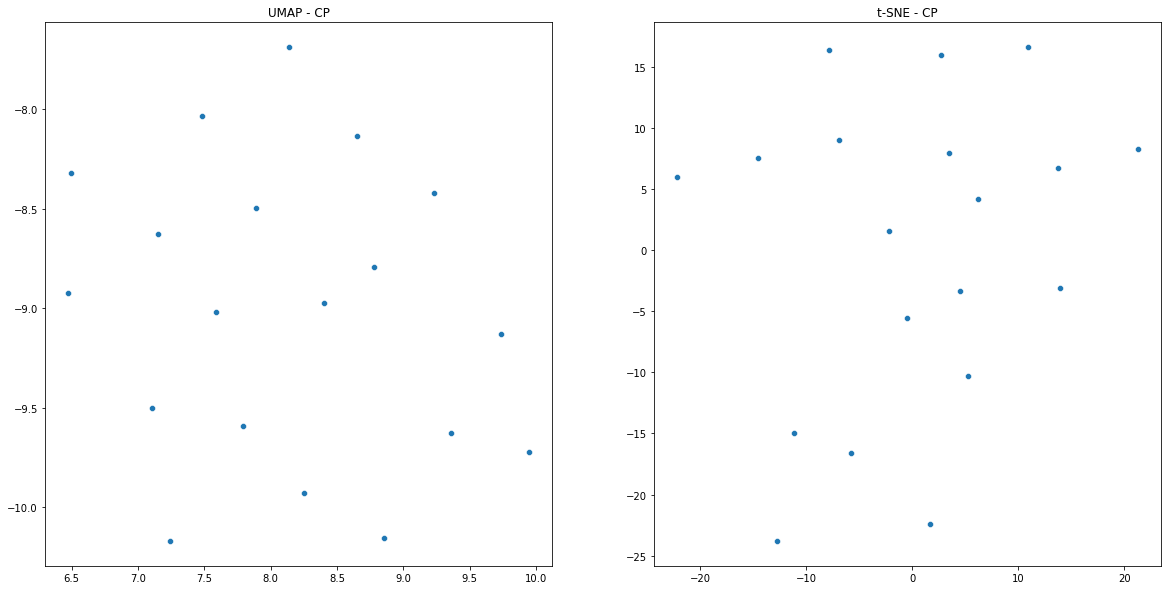

In [29]:
p_list = ['ЕР', 'КПРФ', 'ЛДПР', 'СР']

for p in p_list:

    X = df_t.loc[dep_df_cr[dep_df_cr == p].index, :]
    y = dep_df_cr[dep_df_cr == p]

    embedding = reducer.fit_transform(X)
    tsne_transformed = tsne.fit_transform(X)

    plt.figure(figsize=(20,10))

    ax1 = plt.subplot(1, 2, 1)
    sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1])
    ax1.set_title(f"UMAP - {p}")

    ax2 = plt.subplot(1, 2, 2)
    sns.scatterplot(tsne_transformed[:,0], tsne_transformed[:,1])
    ax2.set_title(f"t-SNE - {p}")

    plt.show()

Исходя из картинок, которые дают UMAP и t-SNE, явная кластеризация внутри партий отсутствует

## DBSCAN

In [30]:
def dbscan_clustering(eps_range, X):
    eps_range = eps_range
    silhouette = []
    clusters = []
    for i in tqdm(eps_range):
        dbscan = DBSCAN(eps=i, n_jobs=-1).fit(X)
        labels = dbscan.labels_
        uniq_labels = np.unique(labels)
        n_clusters = len(uniq_labels[uniq_labels != -1])
        if n_clusters > 1:
            score = silhouette_score(X, labels, random_state=7)
        else:
            score = 0
        silhouette.append(score)
        clusters.append(n_clusters)
        
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.plot(eps_range, silhouette, marker='o', color=color)
    ax1.set_xlabel('eps')
    ax1.set_ylabel('silhouette', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.plot(eps_range, clusters, marker='o', color=color)
    ax2.set_ylabel('n_clusters', color=color)  
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

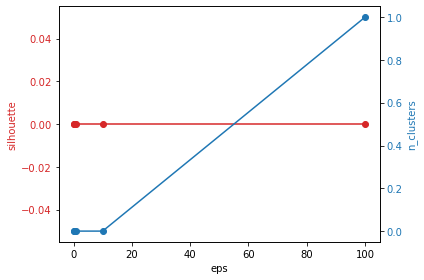

In [31]:
eps_range = [0.01, 0.1, 1, 10, 100]
dbscan_clustering(eps_range, np.array(X))

DBSCAN не справился с кластеризацией, видимо из-за огромного количества фичей